In [1]:
import os
import keras
import numpy as np
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2

In [2]:
print("Доступные устройства:")
print(tf.config.list_physical_devices())

Доступные устройства:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Загрузка данных
!mkdir /content/coco
!cd /content/coco
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

!unzip train2017.zip -d /content/coco
!unzip val2017.zip -d /content/coco
!unzip annotations_trainval2017.zip -d /content/coco

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: /content/coco/val2017/000000365745.jpg  
 extracting: /content/coco/val2017/000000320425.jpg  
 extracting: /content/coco/val2017/000000481404.jpg  
 extracting: /content/coco/val2017/000000314294.jpg  
 extracting: /content/coco/val2017/000000335328.jpg  
 extracting: /content/coco/val2017/000000513688.jpg  
 extracting: /content/coco/val2017/000000158548.jpg  
 extracting: /content/coco/val2017/000000132116.jpg  
 extracting: /content/coco/val2017/000000415238.jpg  
 extracting: /content/coco/val2017/000000321333.jpg  
 extracting: /content/coco/val2017/000000081738.jpg  
 extracting: /content/coco/val2017/000000577584.jpg  
 extracting: /content/coco/val2017/000000346905.jpg  
 extracting: /content/coco/val2017/000000433980.jpg  
 extracting: /content/coco/val2017/000000228144.jpg  
 extracting: /content/coco/val2017/000000041872.jpg  
 extracting: /content/coco/val2017/000000117492.jpg  
 extracting: /

In [4]:
data_dir = '/content/coco'
data_type = 'train2017'
ann_file = '{}/annotations/instances_{}.json'.format(data_dir, data_type)

batch_size = 8
img_size = (256, 256)

In [5]:
def getImgPersonIds(coco):
  cat_ids = coco.getCatIds(catNms=['person'])
  min_human_size = 0.2
  max_human_size = 0.7
  human_count = 3

  # Получаем идентификаторы изображений, где находится не более трёх человек
  image_ids = []
  for person_id in cat_ids:
    img_ids = coco.getImgIds(catIds=[person_id])
    for img_id in img_ids:
        # Загружаем изображение
        img = coco.loadImgs(img_id)[0]
        img_sz = img['height'] * img['width']

        # Загружаем аннотации
        ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=[person_id])
        annotations = coco.loadAnns(ann_ids)

        # Считаем какую площадь занимают люди
        human_size = sum([ann['area'] for ann in annotations]) / img_sz

        if ((len(annotations) <= human_count) and (human_size > min_human_size) and (human_size < max_human_size)):
            image_ids.append(img_id)

  return image_ids

In [6]:
# Подготовка данных
# Train

coco_train = COCO(ann_file)
cat_ids = coco_train.getCatIds(catNms=['person'])

loading annotations into memory...
Done (t=18.45s)
creating index...
index created!


In [7]:
imgIds_train = getImgPersonIds(coco_train)
images_train = coco_train.loadImgs(imgIds_train)

In [8]:
print(f'Размер тренировочного датасета: {len(images_train)}')

Размер тренировочного датасета: 11832


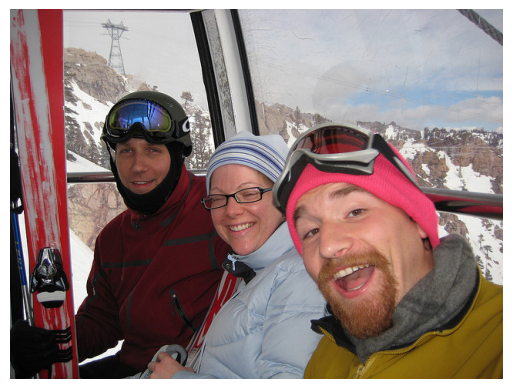

img name:  000000434618.jpg


In [96]:
# Загрузка и отображение случайного изображения
from PIL import Image
import skimage.io as io

demo_img = coco_train.loadImgs(imgIds_train[np.random.randint(0,len(imgIds_train))])[0]
I = io.imread('{}/{}/{}'.format(data_dir, data_type, demo_img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()
print('img name: ', demo_img['file_name'])

In [10]:
# Функция для проверки, пересекаются ли два баундинг-бокса
def bbox_intersect(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Проверка пересечения по осям x и y
    x_intersect = (x1 < x2 + w2) and (x2 < x1 + w1)
    y_intersect = (y1 < y2 + h2) and (y2 < y1 + h1)

    return x_intersect and y_intersect

In [11]:
# Ищем классы переносных предметов, чтобы включить их в маску
category_ids = coco_train.getCatIds()
filterClasses = []

for ids in category_ids:
  cats = coco_train.loadCats(ids=ids)
  if (cats[0]['supercategory'] in ['person', 'accessory', 'sports']) or (cats[0]['name'] in ['teddy bear', 'toothbrush']):
    filterClasses.append(cats[0]['id'])

print(filterClasses)
print(len(filterClasses))

[1, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 88, 90]
18


In [12]:
def get_ann_ids(coco, img_id):
  cat_ids = coco.getCatIds(catNms=['person'])

  # Загружаем аннотации людей
  annIds = coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=0)
  anns = coco.loadAnns(annIds)

  # Загружаем аннотации всех объектов
  all_annIds = coco.getAnnIds(imgIds=img_id)
  all_anns = coco.loadAnns(all_annIds)

  # Ищем переносные предметы и записываем id их аннотаций
  ann_ids = []

  for i in range(len(anns)):
    for a in all_anns:
      is_inside = bbox_intersect(a['bbox'], anns[i]['bbox'])
      if((is_inside == True) and (a['category_id'] in filterClasses) and (a['id'] not in ann_ids)):
        ann_ids.append(a['id'])

  return ann_ids

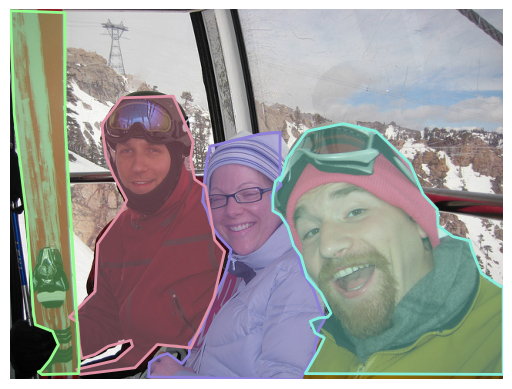

In [97]:
plt.axis('off')
plt.imshow(I)

anns = coco_train.loadAnns(get_ann_ids(coco_train, demo_img['id']))

coco_train.showAnns(anns)

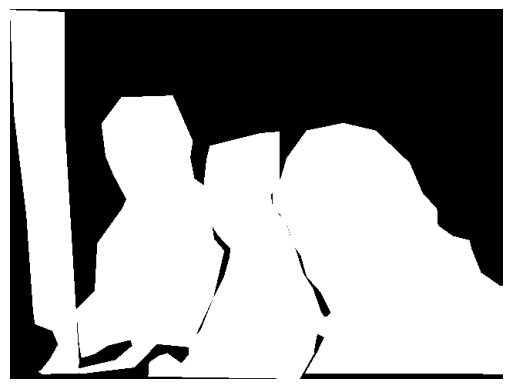

In [98]:
height, width = demo_img['height'], demo_img['width']

mask = np.zeros((height, width), dtype=np.uint8)

for ann in anns:
    mask = mask | coco_train.annToMask(ann)

plt.axis('off')
plt.imshow(mask, cmap='gray')

In [13]:
!mkdir /content/coco/masks_train2017

In [14]:
train_img_names = []
val_img_names = []

TRAIN_DIR = '/content/coco/train2017'
TRAIN_MASKS_DIR = '/content/coco/masks_train2017'

VAL_DIR = '/content/coco/val2017'
VAL_MASKS_DIR = '/content/coco/masks_val2017'

In [15]:
# Создание и сохранение масок для тренировочного датасета
for img in images_train:
  file_path = '{}/{}'.format(TRAIN_MASKS_DIR, img['file_name'])
  train_img_names.append(img['file_name'])

  anns = coco_train.loadAnns(get_ann_ids(coco_train, img['id']))

  mask = coco_train.annToMask(anns[0])
  for i in range(len(anns)):
    mask = mask | coco_train.annToMask(anns[i])

  mask = Image.fromarray(mask * 255, mode="L")
  mask.save(file_path)

In [16]:
print(len(train_img_names))

11832


In [17]:
# Val
data_type = 'val2017'
ann_file = '{}/annotations/instances_{}.json'.format(data_dir, data_type)

coco_val = COCO(ann_file)
cat_ids = coco_val.getCatIds(catNms=['person'])

loading annotations into memory...
Done (t=1.99s)
creating index...
index created!


In [18]:
imgIds_val = getImgPersonIds(coco_val)
images_val = coco_val.loadImgs(imgIds_val)

In [19]:
print(f'Размер валидационного датасета: {len(images_val)}')

Размер валидационного датасета: 474


In [20]:
!mkdir /content/coco/masks_val2017

In [21]:
# Создание и сохранение масок для валидационного датасета
for img in images_val:
  file_path = '{}/{}'.format(VAL_MASKS_DIR, img['file_name'])
  val_img_names.append(img['file_name'])

  anns = coco_val.loadAnns(get_ann_ids(coco_val, img['id']))

  mask = coco_val.annToMask(anns[0])
  for i in range(len(anns)):
    mask = mask | coco_val.annToMask(anns[i])

  mask = Image.fromarray(mask * 255, mode="L")
  mask.save(file_path)

In [22]:
import numpy as np
import albumentations as A
import cv2

transform1 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5)
])

transform2 = A.Compose([
    A.CenterCrop(height=224, width=224, p=0.2),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5)
])

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, file_names, images_path, masks_path, batch_size=32, image_size=(256, 256), augmentations=None):
        self.file_names = file_names
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.augmentations = augmentations


    def __len__(self):
        return int(np.ceil(len(self.file_names) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch = self.file_names[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for i in range(len(batch)):
            image = cv2.imread('{}/{}'.format(self.images_path, batch[i]))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread('{}/{}'.format(self.masks_path, batch[i]), cv2.IMREAD_GRAYSCALE)

            if(len(image.shape) < 3):
              continue

            if self.augmentations:
                augmented = self.augmentations(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            # Приведение размера изображения и маски
            image = cv2.resize(image, self.image_size)
            mask = cv2.resize(mask, self.image_size)
            mask = np.expand_dims(mask, axis=-1)

            # Нормализация значений пикселей изображения
            image = image / 255.0
            mask = mask / 255.0

            images.append(image)
            masks.append(mask)


        images = np.array(images)
        masks = np.array(masks)

        return images, masks



    def on_epoch_end(self):
        np.random.shuffle(self.file_names)


In [23]:
from sklearn.model_selection import train_test_split

train_img_names, test_img_names = train_test_split(train_img_names, test_size=0.1, random_state=42)

In [24]:
train_dataset = CustomDataGenerator(train_img_names, TRAIN_DIR, TRAIN_MASKS_DIR, batch_size, img_size, augmentations=transform1)
test_dataset = CustomDataGenerator(test_img_names, TRAIN_DIR, TRAIN_MASKS_DIR, batch_size, img_size)
valid_dataset = CustomDataGenerator(val_img_names, VAL_DIR, VAL_MASKS_DIR, batch_size, img_size)

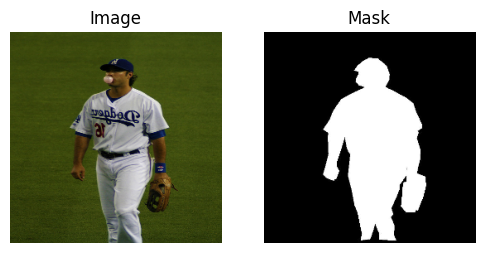

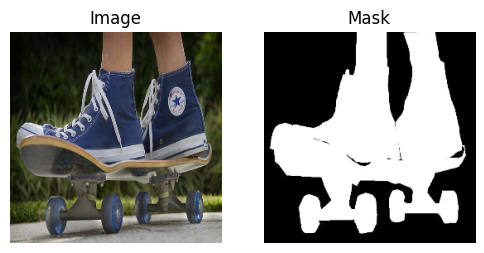

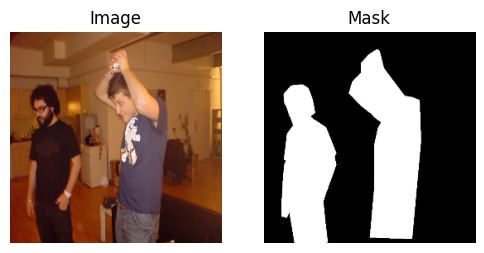

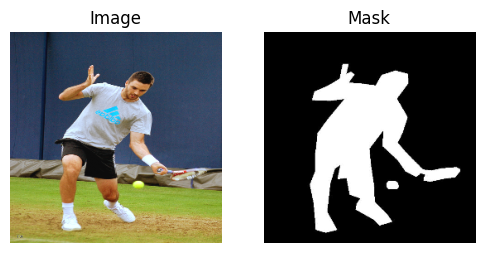

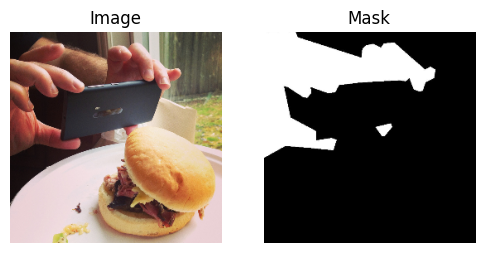

In [115]:
images, masks = train_dataset.__getitem__(4)

# Визуализация первых нескольких изображений и их масок
num_images_to_visualize = 5

for i in range(num_images_to_visualize):
    plt.figure(figsize=(6, 3))

    # Изображение
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])
    plt.title('Image')
    plt.axis('off')

    # Маска
    plt.subplot(1, 2, 2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')

plt.show()

In [25]:
from keras import layers, models

def conv_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Кодировщик
    c1 = conv_block(inputs, 64)
    c1 = conv_block(c1, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    c2 = conv_block(c2, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    c3 = conv_block(c3, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    c4 = conv_block(c4, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 1024)
    c5 = conv_block(c5, 1024)

    # Декодер
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 512)
    c6 = conv_block(c6, 512)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 256)
    c7 = conv_block(c7, 256)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 128)
    c8 = conv_block(c8, 128)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 64)
    c9 = conv_block(c9, 64)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Создаем модель
model = unet_model(img_size + (3,))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 256, 256, 64)         0         ['batch_normalization[0][0

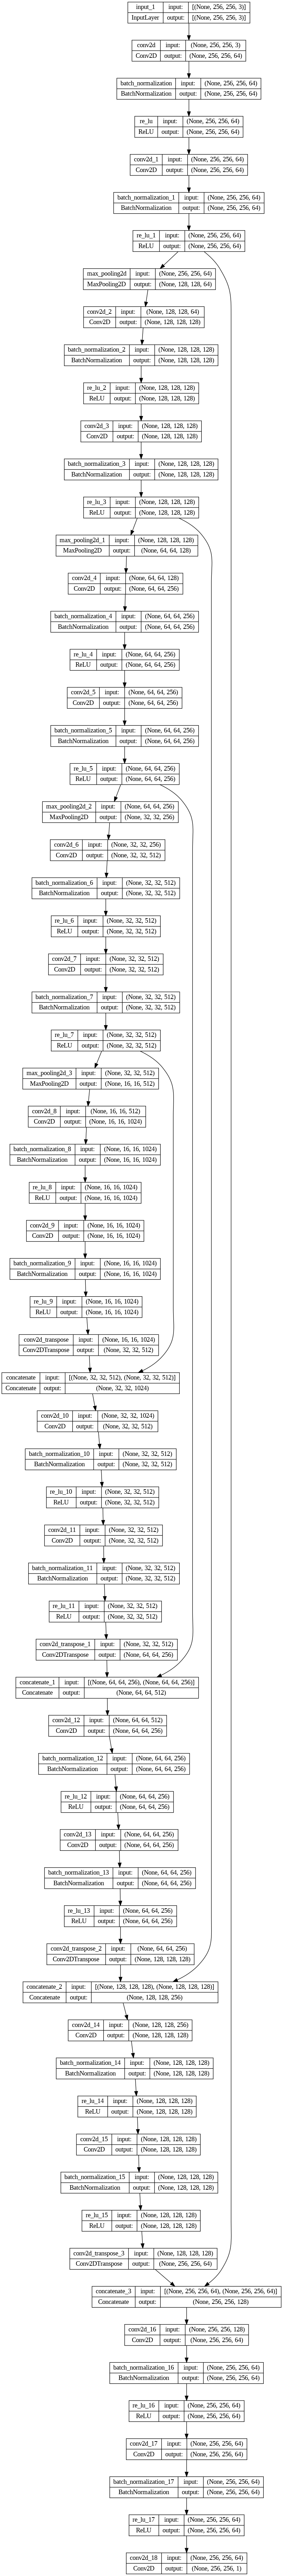

In [117]:
keras.utils.plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

In [26]:
# Метрики
bin_iou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
recall = tf.keras.metrics.Recall(),
precision = tf.keras.metrics.Precision()
mean_bin_iou = keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)

In [172]:
checkpoint_filepath = "/content/drive/MyDrive/models/unet_7_256_8.h5"

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                    monitor='val_loss',
                                    mode="min",
                                    save_weights_only=True,
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                    patience=10)
]

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy', metrics=['accuracy', bin_iou, mean_bin_iou, recall, precision])

In [125]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
1331/1331 [==============================] - 733s 527ms/step - loss: 0.1879 - accuracy: 0.8997 - binary_io_u: 0.8149 - binary_io_u_1: 0.8547 - recall: 0.8717 - precision: 0.9479 - val_loss: 0.2362 - val_accuracy: 0.8671 - val_binary_io_u: 0.7493 - val_binary_io_u_1: 0.8028 - val_recall: 0.8039 - val_precision: 0.9285
Epoch 2/10
1331/1331 [==============================] - 703s 528ms/step - loss: 0.1465 - accuracy: 0.9062 - binary_io_u: 0.8301 - binary_io_u_1: 0.8668 - recall: 0.8806 - precision: 0.9562 - val_loss: 0.2611 - val_accuracy: 0.8643 - val_binary_io_u: 0.7435 - val_binary_io_u_1: 0.7976 - val_recall: 0.8056 - val_precision: 0.9208
Epoch 3/10
1331/1331 [==============================] - 695s 522ms/step - loss: 0.1377 - accuracy: 0.9086 - binary_io_u: 0.8359 - binary_io_u_1: 0.8714 - recall: 0.8834 - precision: 0.9595 - val_loss: 0.2663 - val_accuracy: 0.8607 - val_binary_io_u: 0.7393 - val_binary_io_u_1: 0.7887 - val_recall: 0.8490 - val_precision: 0.8829
Epoch 4/10

In [28]:
# Загрузка весов модели

weights_filepath = "/content/drive/MyDrive/models/unet_7_256_8.h5"

model.load_weights(weights_filepath)

In [122]:
# Визуализация результатов
from sklearn.metrics import confusion_matrix

def print_result(model, index):
  # Загрузим изображение из валидационного набора данных
  image = cv2.imread('{}/{}'.format(VAL_DIR, val_img_names[index]))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, img_size)
  image = image / 255.0

  ground_truth_mask = cv2.imread('{}/{}'.format(VAL_MASKS_DIR, val_img_names[index]))
  ground_truth_mask = cv2.resize(ground_truth_mask, img_size)

  # Пропустим изображение через модель для получения предсказания
  predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]
  print(predicted_mask.shape)

  # Отобразим изображение и маски
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(image)
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(ground_truth_mask, cmap='gray')
  plt.title('Ground-truth mask')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(predicted_mask.squeeze(), cmap='gray')
  plt.title('Predicted Mask')
  plt.axis('off')

  plt.show()

1/1 [==============================] - 2s 2s/step
(256, 256, 1)


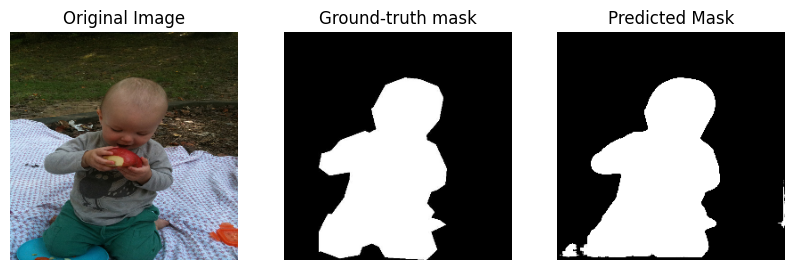

In [48]:
print_result(model, 5)

1/1 [==============================] - 0s 61ms/step
(256, 256, 1)


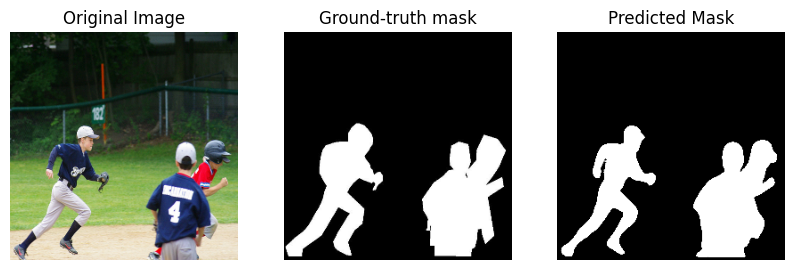

In [228]:
print_result(model, 12)

1/1 [==============================] - 0s 29ms/step
(256, 256, 1)


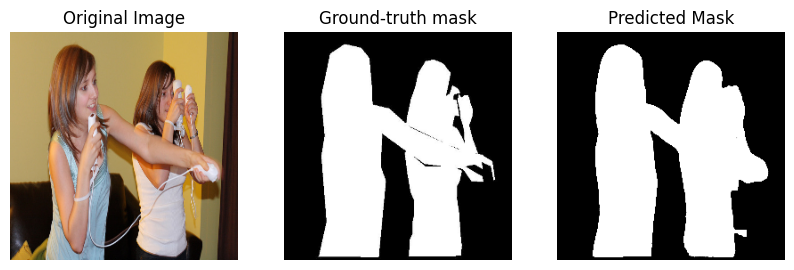

In [229]:
print_result(model, 13)

In [33]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt
from PIL import Image

def load_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

def predict_mask(model, image):
    pred_mask = model.predict(image)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    return pred_mask

def apply_mask(image_path, mask, target_size):
    original_img = load_img(image_path)
    original_img = img_to_array(original_img)

    mask = array_to_img(mask)
    mask = mask.resize(original_img.shape[:2][::-1], resample=Image.NEAREST)
    mask = img_to_array(mask)

    masked_img = original_img * (mask / 255)

    # Применение маски на белый фон
    white_bg = np.ones_like(original_img) * 255
    masked_img = original_img * (mask / 255) + white_bg * (1 - (mask / 255))

    return masked_img.astype(np.uint8)


def replace_bg(model):
  image_path = '{}/{}'.format(VAL_DIR, val_img_names[np.random.randint(0, len(val_img_names))])

  # Загрузка изображения
  image = load_image(image_path, img_size)

  # Предсказание маски
  pred_mask = predict_mask(model, image)

  # Применение маски
  masked_image = apply_mask(image_path, pred_mask, img_size)

  plt.figure(figsize=(10, 5))

  d_img = load_img(image_path)
  plt.subplot(1, 3, 1)
  plt.imshow(d_img)
  plt.title('Image')
  plt.axis('off')

  d_mask = array_to_img(pred_mask)
  d_mask = d_mask.resize(img_to_array(d_img).shape[:2][::-1], resample=Image.NEAREST)
  plt.subplot(1, 3, 2)
  plt.imshow(d_mask, cmap='gray')
  plt.title('Mask')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(masked_image)
  plt.title('Result')
  plt.axis('off')

  plt.show()

1/1 [==============================] - 0s 28ms/step


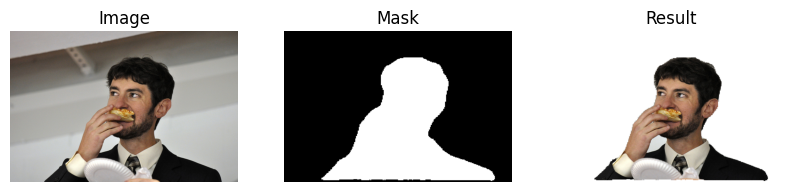

In [40]:
replace_bg(model)

1/1 [==============================] - 6s 6s/step


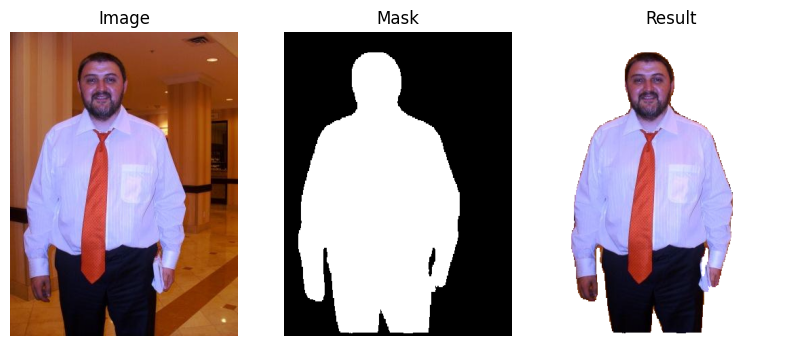

In [123]:
replace_bg(model)

1/1 [==============================] - 0s 22ms/step


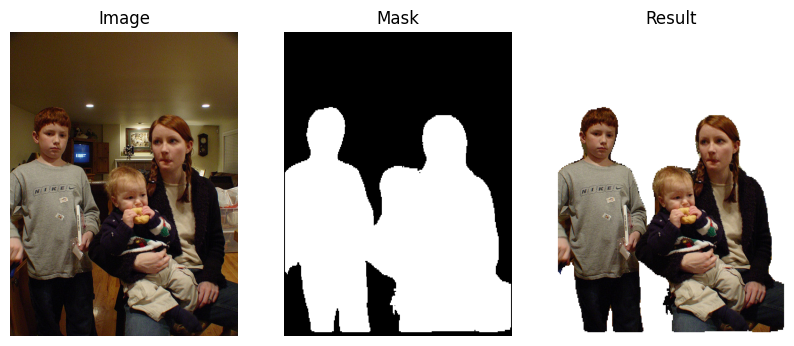

In [215]:
replace_bg(model)

1/1 [==============================] - 0s 33ms/step


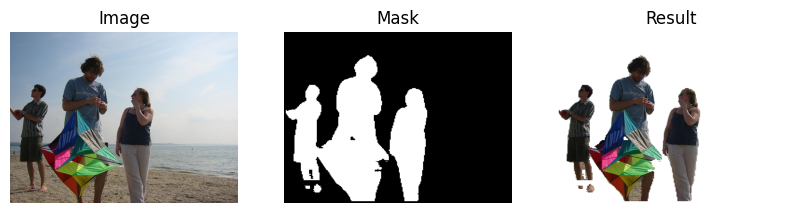

In [227]:
replace_bg(model)

In [124]:
# Вывод метрик
metrics = model.evaluate(test_dataset)

148/148 [==============================] - 38s 178ms/step - loss: 1.5460 - accuracy: 0.8778 - binary_io_u: 0.7718 - binary_io_u_1: 0.8184 - recall: 0.8381 - precision: 0.9257
